# Installing dependencies

In [ ]:
! pip install livelossplot

In [ ]:
import pandas as pd
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
#Code to keep colab running
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

# Preparation

## Prepare Covid-Net dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip -qq drive/My\ Drive/data_balanced.zip

# Importing data

In [ ]:
import pandas as pd
from keras.utils import to_categorical
import numpy as np

np.random.seed(7)

train_data = pd.read_csv('drive/My Drive/filesAAII/train_split_v3_augmented.csv', sep=',', index_col=0)
print(train_data.head())


test_data = pd.read_csv('drive/My Drive/filesAAII/test_split_v3.txt', header=None, sep=' ', names=['id','image', 'result', 'type1', 'type2'])
test_data.head(1)


image_height = 150
image_width = 150

                                     id  ... type2
0  21e403ae-139b-4419-b3fa-0bf13d97d245  ...   NaN
1  5458205b-c67a-44de-a1e3-009f977b4f98  ...   NaN
2  4769fa12-e694-48ce-ad4e-0628e5dd75f0  ...   NaN
3  c8b05677-ce24-4967-a152-3602c5332c4c  ...   NaN
4  d8fe9c83-74df-4ca8-8075-012b6f1076bc  ...   NaN

[5 rows x 5 columns]


In [ ]:
print(train_data['result'].unique())
train_data[train_data['result'] == 'COVID-19'].count()

['normal' 'pneumonia' 'COVID-19']


id         223
image     1561
result    1561
type1      196
type2       27
dtype: int64

In [ ]:
print(test_data['result'].unique())
test_data[test_data['result'] == 'COVID-19'].count()

['pneumonia' 'COVID-19' 'normal']


id        31
image     31
result    31
type1     31
type2      8
dtype: int64

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32 #10

train_generator = ImageDataGenerator(
    rescale=1/255
)

test_generator = ImageDataGenerator(
    rescale=1/255
)

train_set = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='image',
    directory="train/",
    y_col='result',
    shuffle=True,
    target_size=(image_width, image_height),
    batch_size = batch_size,
    class_mode='categorical'
)

test_set = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = batch_size,
    class_mode='categorical'
)

Found 4961 validated image filenames belonging to 3 classes.
Found 1510 validated image filenames belonging to 3 classes.


## Analysing Data

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


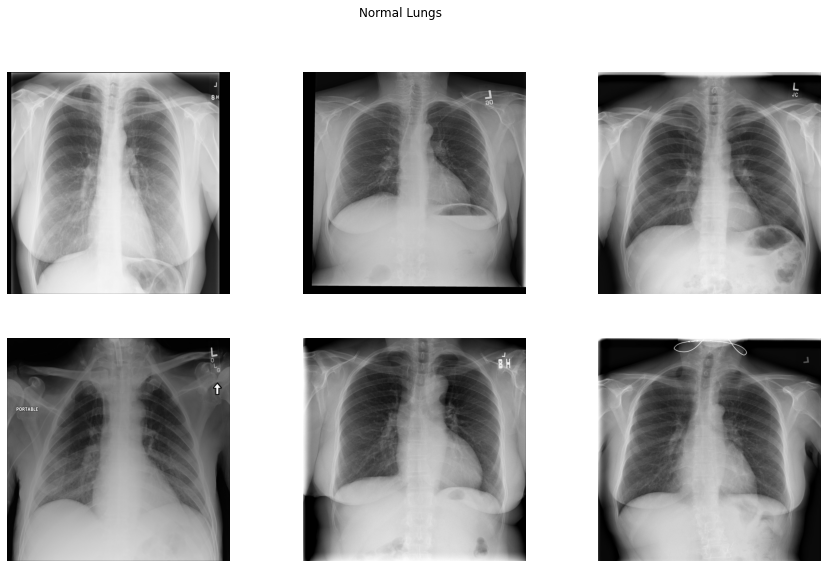

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

f,ax = plt.subplots(2,3,figsize=(15,9))
samples_normal = train_data[train_data['result'] == 'normal']['image']

for i in range(0,6):
  im = cv2.imread('train/' + samples_normal.iloc[i])
  print(im.shape)
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Normal Lungs')
plt.show()

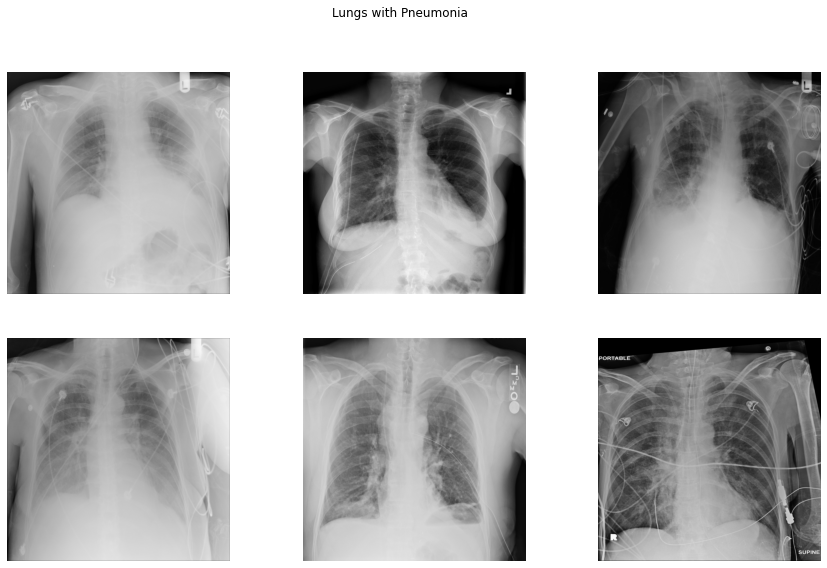

In [ ]:
f,ax = plt.subplots(2,3,figsize=(15,9))
samples_normal = train_data[train_data['result'] == 'pneumonia']['image']

for i in range(0,6):
  im = cv2.imread('train/' + samples_normal.iloc[i])
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Lungs with Pneumonia')
plt.show()

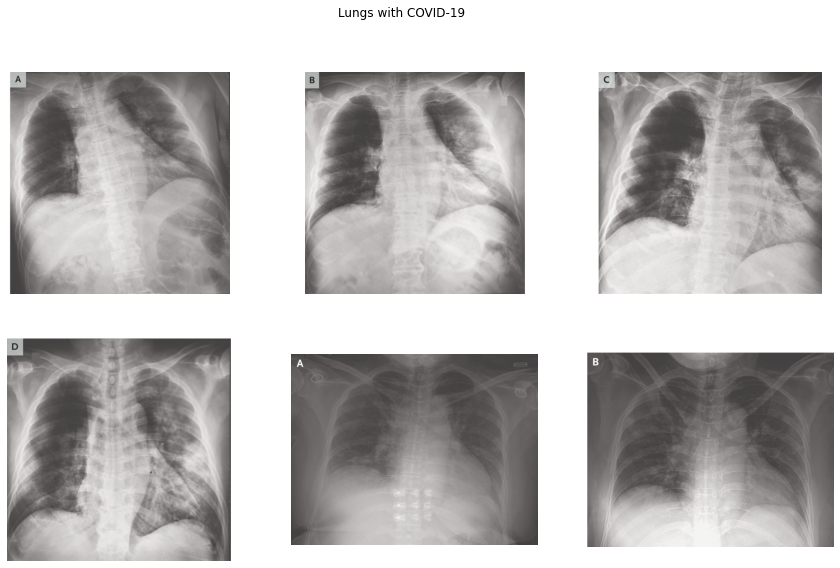

In [ ]:
f,ax = plt.subplots(2,3,figsize=(15,9))
samples_normal = train_data[train_data['result'] == 'COVID-19']['image']

for i in range(0,6):
  im = cv2.imread('train/' + samples_normal.iloc[i])
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Lungs with COVID-19')
plt.show()

<Figure size 432x288 with 0 Axes>

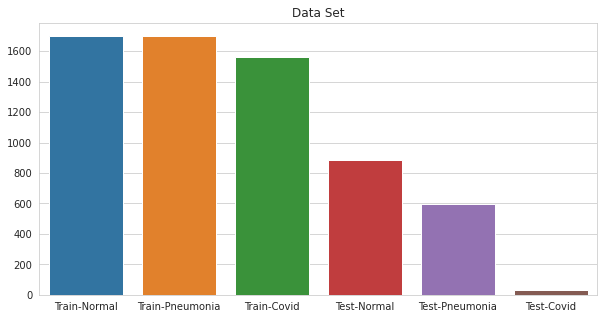

In [ ]:
sns.set_style('whitegrid')
plt.figure()
plt.subplots(figsize=(10,5))
grafico=sns.barplot(x=['Train-Normal','Train-Pneumonia','Train-Covid','Test-Normal','Test-Pneumonia','Test-Covid'],
                    y=[train_data[train_data['result'] == 'normal'].shape[0],
                       train_data[train_data['result'] == 'pneumonia'].shape[0],
                       train_data[train_data['result'] == 'COVID-19'].shape[0],
                       test_data[test_data['result'] == 'normal'].shape[0],
                       test_data[test_data['result'] == 'pneumonia'].shape[0],
                       test_data[test_data['result'] == 'COVID-19'].shape[0]
                    ]) 
grafico.set_title('Data Set')
plt.show()

# Developing model

## Auxiliary Functions

In [ ]:
import os

def save_model_on_cloud(model,name,ind):
  path="/content/drive/My Drive/covid_runs/run"+ind
  os.makedirs(path)
  model.save_weights(path + "/last_run" + name + ".hdf5")
  json_model = model.to_json()
  with open(path + "/" + name + ".json", "w") as json_file:
    json_file.write(model_json)
  os.rename("best_weights_" + name + ".hdf5", path + "/best_weights_" + name + ".hdf5")

In [ ]:
from keras.models import model_from_json
import json

def load_model_from_cloud(model_path, weights_path):
  with open(model_path, 'r') as json_file:
    architecture  = json.load(json_file)
    model = model_from_json(json.dumps(architecture))
  model.load_weights(weights_path)
  return model

In [ ]:
import cv2
def query_model(model, img):
  tmp_image = cv2.imread(img)
  tmp_image = np.array(tmp_image)
  tmp_image = cv2.resize(tmp_image, (image_width, image_height))
  tmp_image = tmp_image / 255
  res = model.predict(np.expand_dims(tmp_image, axis=0))
  print(test_set.class_indices)
  ind = np.argmax(res)
  print(ind)
  print([t * 100 for t in res])

## Importing pre-trained model 

#### Model 1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D,MaxPooling2D
import keras
from keras.models import Model,Sequential
from keras.optimizers import Adam, RMSprop




model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(image_height,image_width, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(150,150, 3)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3 , activation='softmax'))




opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 37, 37, 64)       

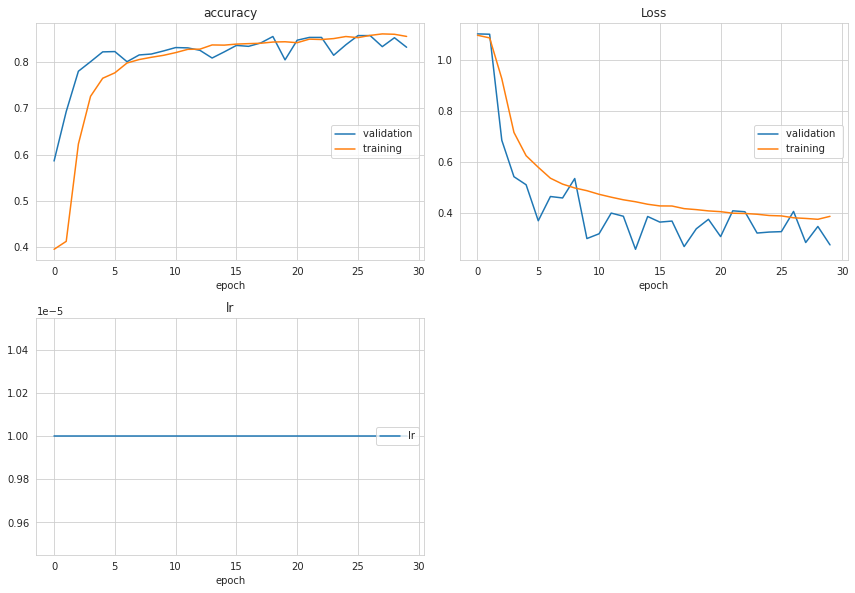

accuracy
	validation       	 (min:    0.586, max:    0.856, cur:    0.831)
	training         	 (min:    0.396, max:    0.860, cur:    0.854)
Loss
	validation       	 (min:    0.258, max:    1.103, cur:    0.275)
	training         	 (min:    0.375, max:    1.098, cur:    0.387)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00030: val_loss did not improve from 0.25776


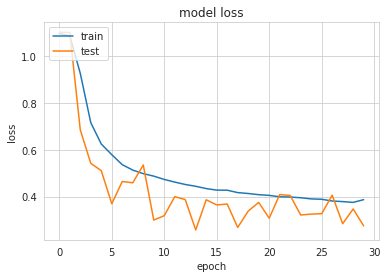

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
import os

no_of_epochs  = 30 #10
path="/content/drive/My Drive/covid_runs/models/model_1/"

os.makedirs(path)
json_model = model.to_json()
with open(path+"model.json", "w") as json_file:
  json_file.write(json_model)

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
plotlosses = PlotLossesKeras()
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath=path+'best_weights_xception.hdf5',monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [reduce_learning_rate, plotlosses, checkpoint]


history = model.fit_generator(
    train_set,
    epochs = no_of_epochs,
    validation_data=test_set,
    callbacks=callbacks
)

model.save_weights(path + "last_run.hdf5")

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "accuracy.png")
# summarize history for loss
plt.close()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "loss.png")

In [ ]:
model_cloud = load_model_from_cloud("/content/drive/My Drive/covid_runs/models/model_1/model.json", "/content/drive/My Drive/covid_runs/models/model_1/best_weights_models.hdf5")
model_cloud.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 37, 37, 64)       

In [ ]:
predict_datagen = ImageDataGenerator(rescale=1./255)

predict_set = predict_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = 1,
    class_mode='categorical'
)

filenames = predict_set.filenames
nb_samples = len(filenames)

Found 1510 validated image filenames belonging to 3 classes.


In [ ]:
predict = model_cloud.predict_generator(predict_set,steps = nb_samples)

In [ ]:
res = []
for i in predict:
  if i[0] > 0.5:
    res.append(0)
  elif i[1] > 0.5:
    res.append(1)
  else:
    res.append(2)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(predict_set.classes, res, normalize='true')
cr = classification_report(predict_set.classes, res, target_names=['Covid-19','Normal', 'Pneumonia'])
#print(cm)
print(cr)

              precision    recall  f1-score   support

    Covid-19       0.28      0.55      0.37        31
      Normal       0.93      0.73      0.82       885
   Pneumonia       0.70      0.88      0.78       594

    accuracy                           0.79      1510
   macro avg       0.63      0.72      0.65      1510
weighted avg       0.82      0.79      0.79      1510



Text(0, 0.5, 'Ground truth')

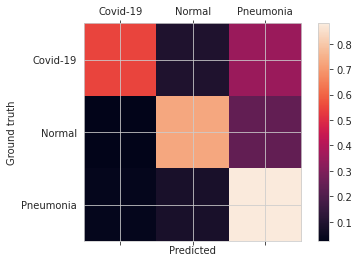

In [ ]:
labels = ['Covid-19','Normal', 'Pneumonia']
fig, ax = plt.subplots()
h = ax.matshow(cm)
fig.colorbar(h)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground truth')

#### Model 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D,MaxPooling2D
import keras
from keras.models import Model,Sequential
from keras.optimizers import Adam, RMSprop

model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3 , activation='softmax'))

opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 34, 34, 64)       

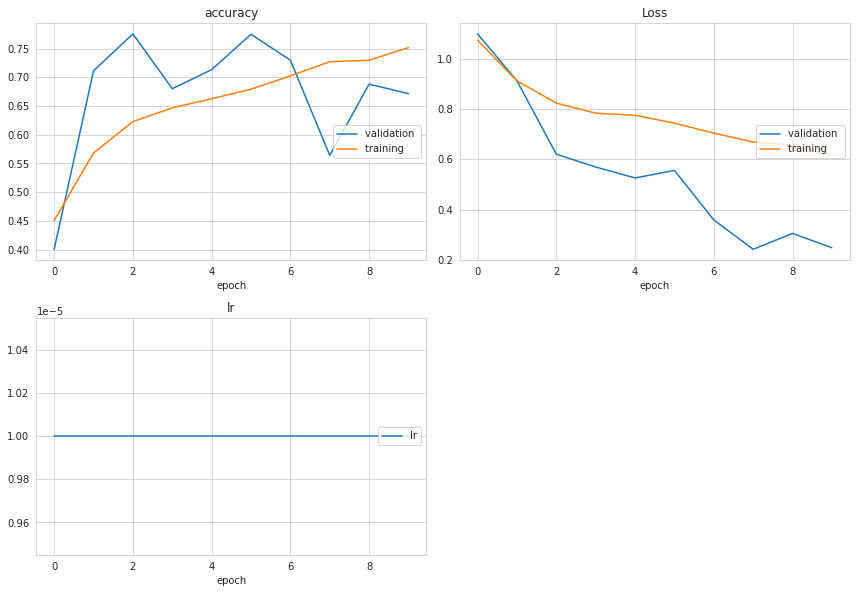

accuracy
	validation       	 (min:    0.401, max:    0.775, cur:    0.672)
	training         	 (min:    0.451, max:    0.752, cur:    0.752)
Loss
	validation       	 (min:    0.242, max:    1.098, cur:    0.248)
	training         	 (min:    0.614, max:    1.073, cur:    0.614)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00010: val_loss did not improve from 0.24201


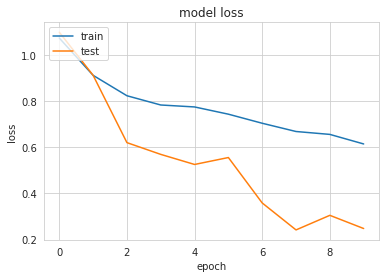

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
import os

no_of_epochs  = 10 #10
path="/content/drive/My Drive/covid_runs/models/model_2/"

os.makedirs(path)
json_model = model.to_json()
with open(path+"model.json", "w") as json_file:
  json_file.write(json_model)

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
plotlosses = PlotLossesKeras()
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath=path+'best_weights_model.hdf5',monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [reduce_learning_rate, plotlosses, checkpoint]


history = model.fit_generator(
    train_set,
    epochs = no_of_epochs,
    validation_data=test_set,
    callbacks=callbacks
)

model.save_weights(path + "last_run.hdf5")

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "accuracy.png")
# summarize history for loss
plt.close()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "loss.png")

In [ ]:
model_cloud = load_model_from_cloud("/content/drive/My Drive/covid_runs/models/model_2/model.json", "/content/drive/My Drive/covid_runs/models/model_2/best_weights_model.hdf5")
model_cloud.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 34, 34, 64)       

In [ ]:
predict_datagen = ImageDataGenerator(rescale=1./255)

predict_set = predict_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = 1,
    class_mode='categorical'
)

filenames = predict_set.filenames
nb_samples = len(filenames)

Found 1510 validated image filenames belonging to 3 classes.


In [ ]:
predict = model_cloud.predict_generator(predict_set,steps = nb_samples)

In [ ]:
res = []
for i in predict:
  if i[0] > 0.5:
    res.append(0)
  elif i[1] > 0.5:
    res.append(1)
  else:
    res.append(2)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(predict_set.classes, res, normalize='true')
cr = classification_report(predict_set.classes, res, target_names=['Covid-19','Normal', 'Pneumonia'])
#print(cm)
print(cr)

              precision    recall  f1-score   support

    Covid-19       0.00      0.00      0.00        31
      Normal       0.95      0.28      0.43       885
   Pneumonia       0.47      0.98      0.63       594

    accuracy                           0.55      1510
   macro avg       0.47      0.42      0.36      1510
weighted avg       0.74      0.55      0.50      1510



Text(0, 0.5, 'Ground truth')

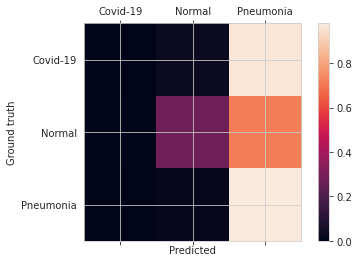

In [ ]:
labels = ['Covid-19','Normal', 'Pneumonia']
fig, ax = plt.subplots()
h = ax.matshow(cm)
fig.colorbar(h)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground truth')

### Model 3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D,MaxPooling2D,BatchNormalization,ZeroPadding2D
import keras
from keras.models import Model,Sequential
from keras.optimizers import Adam, RMSprop

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(image_height,image_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(ZeroPadding2D())

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(ZeroPadding2D())


model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(ZeroPadding2D())

model.add(Conv2D(128, (4, 4), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(MaxPooling2D())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(ZeroPadding2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3 , activation='softmax'))

opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
zero_padding2d_25 (ZeroPaddi (None, 77, 77, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 38, 38, 64)      

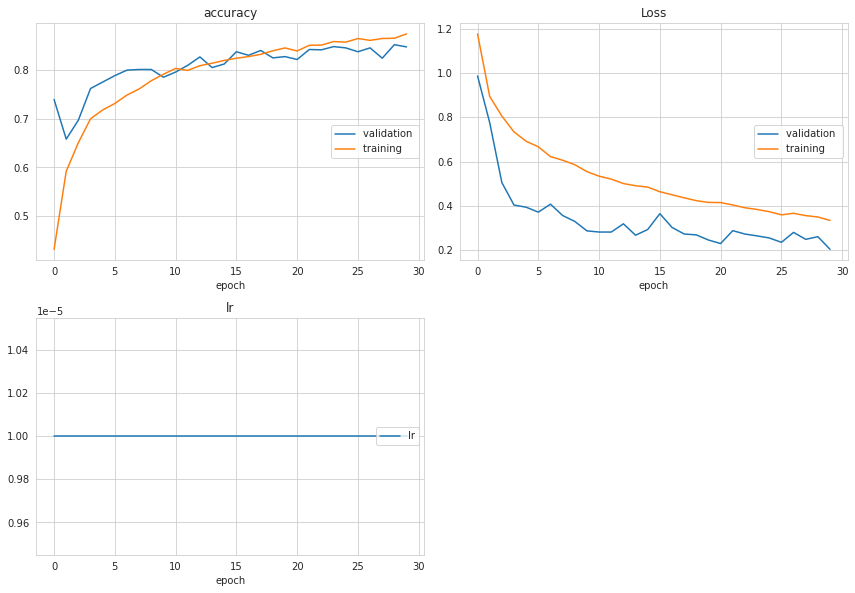

accuracy
	validation       	 (min:    0.658, max:    0.852, cur:    0.848)
	training         	 (min:    0.432, max:    0.874, cur:    0.874)
Loss
	validation       	 (min:    0.204, max:    0.988, cur:    0.204)
	training         	 (min:    0.335, max:    1.177, cur:    0.335)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00030: val_loss improved from 0.23047 to 0.20443, saving model to /content/drive/My Drive/covid_runs/models/model_3/best_weights_model.hdf5


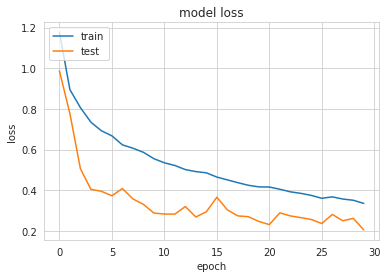

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
import os

no_of_epochs  = 30 #10
path="/content/drive/My Drive/covid_runs/models/model_3/"

os.makedirs(path)
json_model = model.to_json()
with open(path+"model.json", "w") as json_file:
  json_file.write(json_model)

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
plotlosses = PlotLossesKeras()
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath=path+'best_weights_model.hdf5',monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [reduce_learning_rate, plotlosses, checkpoint]


history = model.fit_generator(
    train_set,
    epochs = no_of_epochs,
    validation_data=test_set,
    callbacks=callbacks
)

model.save_weights(path + "last_run.hdf5")

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "accuracy.png")
# summarize history for loss
plt.close()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "loss.png")

In [ ]:
model_cloud = load_model_from_cloud("/content/drive/My Drive/covid_runs/models/model_3/model.json", "/content/drive/My Drive/covid_runs/models/model_3/best_weights_model.hdf5")
model_cloud.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
zero_padding2d_25 (ZeroPaddi (None, 77, 77, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 38, 38, 64)      

In [ ]:
predict_datagen = ImageDataGenerator(rescale=1./255)

predict_set = predict_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = 1,
    class_mode='categorical'
)

filenames = predict_set.filenames
nb_samples = len(filenames)

Found 1510 validated image filenames belonging to 3 classes.


In [ ]:
predict = model_cloud.predict_generator(predict_set,steps = nb_samples)

In [ ]:
res = []
for i in predict:
  if i[0] > 0.5:
    res.append(0)
  elif i[1] > 0.5:
    res.append(1)
  else:
    res.append(2)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(predict_set.classes, res, normalize='true')
cr = classification_report(predict_set.classes, res, target_names=['Covid-19','Normal', 'Pneumonia'])
#print(cm)
print(cr)

              precision    recall  f1-score   support

    Covid-19       0.49      0.55      0.52        31
      Normal       0.92      0.82      0.87       885
   Pneumonia       0.77      0.88      0.82       594

    accuracy                           0.84      1510
   macro avg       0.72      0.75      0.73      1510
weighted avg       0.85      0.84      0.84      1510



Text(0, 0.5, 'Ground truth')

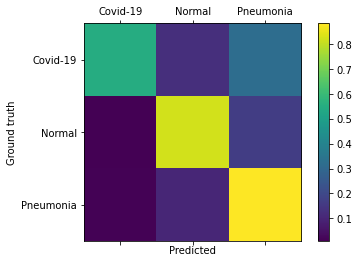

In [ ]:
labels = ['Covid-19','Normal', 'Pneumonia']
fig, ax = plt.subplots()
h = ax.matshow(cm)
fig.colorbar(h)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground truth')

### Model 4

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D,MaxPooling2D,BatchNormalization,ZeroPadding2D
import keras
from keras.models import Model,Sequential
from keras.optimizers import Adam, RMSprop

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(image_height,image_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(ZeroPadding2D())

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(ZeroPadding2D())


model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(ZeroPadding2D())

model.add(Conv2D(128, (4, 4), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(MaxPooling2D())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(ZeroPadding2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3 , activation='softmax'))

opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 77, 77, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 38, 38, 64)       

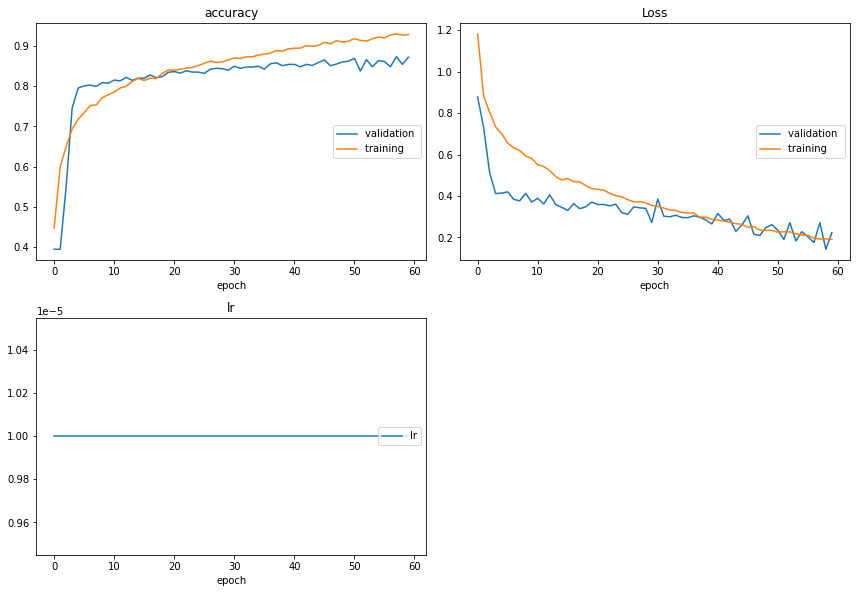

accuracy
	validation       	 (min:    0.393, max:    0.874, cur:    0.873)
	training         	 (min:    0.447, max:    0.931, cur:    0.929)
Loss
	validation       	 (min:    0.143, max:    0.878, cur:    0.223)
	training         	 (min:    0.191, max:    1.182, cur:    0.191)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00060: val_loss did not improve from 0.14281


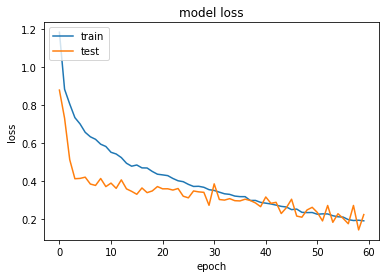

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
import os

no_of_epochs  = 60 #10
path="/content/drive/My Drive/covid_runs/models/model_4/"

os.makedirs(path)
json_model = model.to_json()
with open(path+"model.json", "w") as json_file:
  json_file.write(json_model)

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
plotlosses = PlotLossesKeras()
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath=path+'best_weights_model.hdf5',monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [reduce_learning_rate, plotlosses, checkpoint]


history = model.fit_generator(
    train_set,
    epochs = no_of_epochs,
    validation_data=test_set,
    callbacks=callbacks
)

model.save_weights(path + "last_run.hdf5")

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "accuracy.png")
# summarize history for loss
plt.close()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "loss.png")

In [ ]:
model_cloud = load_model_from_cloud("/content/drive/My Drive/covid_runs/models/model_4/model.json", "/content/drive/My Drive/covid_runs/models/model_4/best_weights_model.hdf5")
model_cloud.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 77, 77, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 38, 38, 64)       

In [ ]:
predict_datagen = ImageDataGenerator(rescale=1./255)

predict_set = predict_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = 1,
    class_mode='categorical'
)

filenames = predict_set.filenames
nb_samples = len(filenames)

Found 1510 validated image filenames belonging to 3 classes.


In [ ]:
predict = model_cloud.predict_generator(predict_set,steps = nb_samples)

In [ ]:
res = []
for i in predict:
  if i[0] > 0.5:
    res.append(0)
  elif i[1] > 0.5:
    res.append(1)
  else:
    res.append(2)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(predict_set.classes, res, normalize='true')
cr = classification_report(predict_set.classes, res, target_names=['Covid-19','Normal', 'Pneumonia'])
#print(cm)
print(cr)

              precision    recall  f1-score   support

    Covid-19       0.56      0.74      0.64        31
      Normal       0.91      0.85      0.88       885
   Pneumonia       0.79      0.86      0.82       594

    accuracy                           0.85      1510
   macro avg       0.75      0.82      0.78      1510
weighted avg       0.86      0.85      0.85      1510



Text(0, 0.5, 'Ground truth')

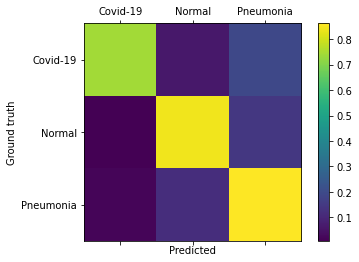

In [ ]:
labels = ['Covid-19','Normal', 'Pneumonia']
fig, ax = plt.subplots()
h = ax.matshow(cm)
fig.colorbar(h)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground truth')